In [51]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from tqdm import tqdm
from tensorflow.keras.layers import Input, Convolution1D, MaxPooling1D, Lambda, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import initializers

In [52]:
# Load the MNIST dataset
(TrainInput, TrainOutput), (TestValInput, TestValOutput) = mnist.load_data()

In [61]:
def check_tensor_sizes(TrainInput, TrainOutput, TestInput, TestOutput, ValInput, ValOutput):
    D = [TrainInput, TrainOutput, TestInput, TestOutput, ValInput, ValOutput]
    totaltrajectories = 0
    
    tensornames = ['train input', 'train output', 'test input', 'test output', 'validation input', 'validation output']
    print(f"{'Tensor Name': <30}{'Shape': <30}")
    print("_"*60)
    for _ in range(len(D)):
        totaltrajectories += D[_].shape[0]
        print(f"{tensornames[_]: <30}{str(D[_].shape): <30}")
        
        if(_ % 2 != 0):
            print('')
        
    print('')
    print("There are ", int(totaltrajectories/2), ' different images with their corresponding labels.')

def BUILD_NEURAL_NETWORK(N_Points, N_Dimensions, N_variables, NetworkScale):
    _tf_INPUT_TENSOR = Input(shape=(N_Points, N_Dimensions))
    
    g = Convolution1D(int(64*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(_tf_INPUT_TENSOR)
    g = Convolution1D(int(64*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(g)

    seg_part1 = g
    g = Convolution1D(int(64*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(g)
    g = Convolution1D(int(128*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(g)
    g = Convolution1D(int(1024*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(g)
    
    global_feature = MaxPooling1D(pool_size=N_Points)(g)
    global_feature = Lambda(exp_dim, arguments={'N_Points': N_Points})(global_feature)

    c = concatenate([seg_part1, global_feature])
    c = Convolution1D(int(512*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(c)
    
    c = Dropout(rate=0.5)(c)  # Adding dropout layer
    
    c = Convolution1D(int(256*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(c)
    c = Convolution1D(int(128*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(c)
    c = Convolution1D(int(128*NetworkScale), 1, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(c)
    prediction = Convolution1D(N_variables, 1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.01), bias_initializer=initializers.Zeros())(c)

    model = Model(inputs=_tf_INPUT_TENSOR, outputs=prediction)
    return model



def print_model_summary(model, kindofNN):

    totalparams = 0
    print("Custom Model Summary of:", kindofNN)
    print(f"{'Layer (type)': <35}{'Output Shape': <30}{'Param #': <15}")
    print("="*100)
    for layer in model.layers:
        totalparams += layer.count_params()
        print(f"{layer.name: <35}{str(layer.output_shape): <30}{layer.count_params(): <15}")
    print('')
    print('Total Parameters: ', totalparams)
    
def add_gaussian_noise(matrix, mean=0, std=0.1):
    noise = np.random.normal(mean, std, size=matrix.shape)
    noisy_matrix = matrix + noise
    return noisy_matrix

def scale_matrix(matrix, new_min=0, new_max=255):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    scaled_matrix = ((matrix - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min
    return scaled_matrix

def expand_matrix(matrix, num_rows_to_add, num_cols_to_add, fill_value=0):
    expanded_matrix = np.pad(matrix, ((num_rows_to_add, num_rows_to_add), (num_cols_to_add, num_cols_to_add)), mode='constant', constant_values=fill_value)
    return expanded_matrix

def shift_matrix(matrix):
    
    shift_amount = np.random.randint(-15, 15, size=2)  # Shifts can be -1, 0, or 1
    shifted_matrix = np.zeros_like(matrix)
    rows, cols = matrix.shape
    for r in range(rows):
        for c in range(cols):
            new_r = (r + shift_amount[0]) % rows
            new_c = (c + shift_amount[1]) % cols
            shifted_matrix[new_r, new_c] = matrix[r, c]
    return shifted_matrix


def show_transformation_progression():
    """
    plt.figure(figsize=(25, 5))

    plt.subplot(1, 6, 1)
    plt.imshow(original_matrix)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(1, 6, 2)
    plt.imshow(rotated_matrix)
    plt.colorbar(shrink=0.5)

    plt.subplot(1, 6, 3)
    plt.imshow(expanded_matrix)
    plt.colorbar(shrink=0.5)

    plt.subplot(1, 6, 4)
    plt.imshow(shifted_matrix)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(1, 6, 5)
    plt.imshow(noisy_matrix)
    plt.colorbar(shrink=0.5)
    
    plt.subplot(1, 6, 6)
    plt.imshow(scaled_noisy_matrix)
    plt.colorbar(shrink=0.5)
    
    plt.show()
    """
    
    
def transform_inputs(TrainInput, TrainOutput, TestInput, TestOutput, ValInput, ValOutput):
    n_TrainInput = []
    n_TestInput = []
    n_ValInput = []

    n_TrainOutput = []
    n_TestOutput = []
    n_ValOutput = []
    
    
    indices = np.arange(0, len(TrainInput), 1)
    for q in tqdm(range(3*len(TrainInput))):
        
        index = np.random.choice(indices)
        original_matrix = TrainInput[index]
        
        rotated_matrix = rotate(original_matrix, np.random.randint(-20, 20), reshape=False)
        expanded_matrix = expand_matrix(rotated_matrix, num_rows_to_add=10, num_cols_to_add=10, fill_value=0)
        shifted_matrix = shift_matrix(expanded_matrix)
        noisy_matrix = add_gaussian_noise(shifted_matrix, mean=0, std=np.random.randint(0, 80))
        scaled_noisy_matrix = scale_matrix(noisy_matrix, new_min=0, new_max=1)
        
        point = []
        for i in range(48):
            for j in range(48):
                point.append([j/48,  (48 - i)/48, scaled_noisy_matrix[i, j]])
            
        n_TrainInput.append(point)
        
        output = np.zeros(10)
        output[TrainOutput[q]] = 1
        n_TrainOutput.append(output.T)
  
    for _ in tqdm(range(len(TestInput) - 4500)):
        
        original_matrix = TestInput[_]
        
        rotated_matrix = rotate(original_matrix, np.random.randint(-20, 20), reshape=False)
        expanded_matrix = expand_matrix(rotated_matrix, num_rows_to_add=10, num_cols_to_add=10, fill_value=0)
        shifted_matrix = shift_matrix(expanded_matrix)
        noisy_matrix = add_gaussian_noise(shifted_matrix, mean=0, std=np.random.randint(0, 80))
        scaled_noisy_matrix = scale_matrix(noisy_matrix, new_min=0, new_max=1)
        

        point = []
        for i in range(48):
            for j in range(48):
                point.append([j/48,  (48 - i)/48, scaled_noisy_matrix[i, j]])
            
        n_TestInput.append(point)
        
        output = np.zeros(10)
        output[TestOutput[_]] = 1
        n_TestOutput.append(output.T)
        
    for _ in tqdm(range(len(ValInput) - 4500)):
        
        original_matrix = ValInput[_]
        
        rotated_matrix = rotate(original_matrix, np.random.randint(-20, 20), reshape=False)
        expanded_matrix = expand_matrix(rotated_matrix, num_rows_to_add=10, num_cols_to_add=10, fill_value=0)
        shifted_matrix = shift_matrix(expanded_matrix)
        noisy_matrix = add_gaussian_noise(shifted_matrix, mean=0, std=np.random.randint(0, 80))
        scaled_noisy_matrix = scale_matrix(noisy_matrix, new_min=0, new_max=1)
        
        point = []
        for i in range(48):
            for j in range(48):
                point.append([j/48, (48 - i)/48, scaled_noisy_matrix[i, j]])
            
        n_ValInput.append(point)
        
        output = np.zeros(10)
        output[ValOutput[_]] = 1
        n_ValOutput.append(output.T)

        
    return np.array(n_TrainInput), np.array(n_TestInput), np.array(n_ValInput), np.array(n_TrainOutput), np.array(n_TestOutput), np.array(n_ValOutput)
    


In [ ]:
N_Points = 48*48
N_Dimensions = 3
N_variables = 10
NetworkScale = 1

In [54]:
ValInput, TestInput, ValOutput, TestOutput = train_test_split(TestValInput, TestValOutput, test_size = 0.5, random_state=31)

check_tensor_sizes(TrainInput, TrainOutput, TestInput, TestOutput, ValInput, ValOutput)

Tensor Name                   Shape                         
____________________________________________________________
train input                   (60000, 28, 28)               
train output                  (60000,)                      

test input                    (5000, 28, 28)                
test output                   (5000,)                       

validation input              (5000, 28, 28)                
validation output             (5000,)                       


There are  70000  different images with their corresponding labels.


In [ ]:
model = BUILD_NEURAL_NETWORK(N_Points, N_Dimensions, N_variables, NetworkScale)

In [62]:
n_TrainInput, n_TestInput, n_ValInput, n_TrainOutput, n_TestOutput, n_ValOutput = transform_inputs(TrainInput, TrainOutput, TestInput, TestOutput, ValInput, ValOutput)

  3%|▎         | 5288/180000 [00:13<07:31, 386.67it/s]


KeyboardInterrupt: 

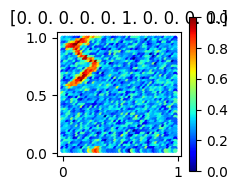

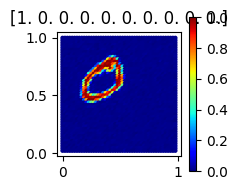

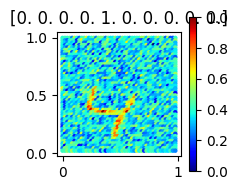

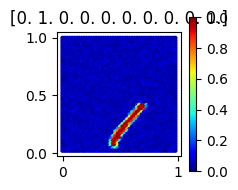

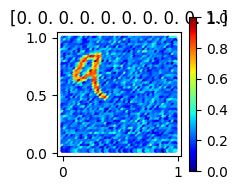

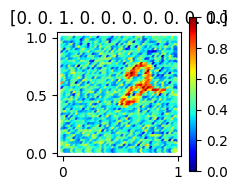

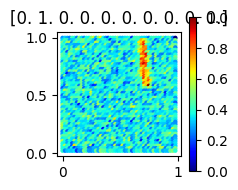

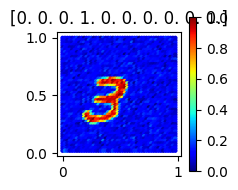

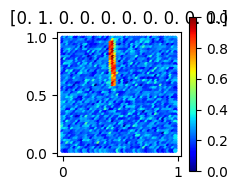

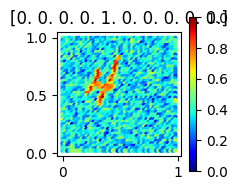

In [60]:
for i in range(10):
    plt.figure(figsize=(2, 2))
    plt.scatter(n_TrainInput[i, :, 0], n_TrainInput[i, :, 1], c= n_TrainInput[i, :, 2], s=5, cmap='jet')
    plt.title(str(n_TrainOutput[i]))
    plt.axis('scaled')
    plt.colorbar()
    plt.show()

In [ ]:
model = creating_Tensorflow_model(kindofNN, input_shape, networkScale, activationFunction)
print_model_summary(model, kindofNN)

learning_rate_piecewise = tf.keras.optimizers.schedules.PiecewiseConstantDecay([int(n_epochs*0.3), int(n_epochs*0.6)],
                                                                               [initial_lr, initial_lr/10, initial_lr/100])
optimizer = keras.optimizers.Adam(learning_rate=learning_rate_piecewise)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])